In [1]:
# computational libraries
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

In [3]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

This cell constructs a DataFrame called X that contains the covariate data. Here, electricity lag, date, and weather lag features are added for a total of 23 covariates.

In [3]:
# create X as a copy of y, then add electricity lag features (be careful with this)
X = pd.DataFrame(y,columns=['elec'])
for i in range(1,7):
    X['elec -'+str(i)] = np.append(np.array([np.nan]*i),X['elec'].values[0:len(y)-i])

# add date features
X['date'] = X.index
X['hourofday'] = X['date'].dt.hour
X['dayofweek'] = X['date'].dt.dayofweek
X['weekofyear'] = X['date'].dt.weekofyear


# process weather features (maybe move this to the end of the weather pipeline before export?)
weather = pd.read_csv('data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')
weather = weather.iloc[:,[0,4]]
for k in weather.columns:
    for i in range(1,7):
        weather[k+' -'+str(i)] = np.append(np.array([np.nan]*i),weather[k].values[0:len(weather)-i])

weather = weather.loc[y.index[0]:y.index[len(y)-1]]

# add weather features, remove NaN's that were introduced with elec lag variables
X = X.join(weather)

# drop useless and reorder columns
X = X[['hourofday','dayofweek','weekofyear',
       'elec -1','elec -2','elec -3','elec -4','elec -5','elec -6',
       'temp','temp -1','temp -2','temp -3','temp -4','temp -5','temp -6',
       'rh','rh -1','rh -2','rh -3','rh -4','rh -5','rh -6']]

# truncate y and X to match each other (this step is only necessary if using elec lag features)
X = X.iloc[6:]
y = y.iloc[6:]

This cell initializes several regression models to be validated. I will continue to update the parameters of these models as I test them individually in separate notebooks.

In [4]:
# initialize model to be tested (in the future, choose one and use this notebook only to cross-validate)

linear_regression = LinearRegression()
    
svm_regression = LinearSVR()
    
decision_tree_regression = DecisionTreeRegressor()
    
mlp_regression = MLPRegressor()

xbg_regression = XGBRegressor(n_estimators=1000)


This cell iteratively trains a model and the uses it to predict the target feature for different subsets of the total dataset. It then adds the MAPE of each prediction to the results dataframe.

In [5]:
# construct empty dataframe to populate with results
results = pd.DataFrame(columns=['hours_trained','mape'])

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-01-10 08:00:00',freq='2D',periods=80)
end_times = split_times.shift(39,freq='H')

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    X_train = X.loc[X.index <= split_times[i]].copy()
    X_test = X.loc[(X.index > split_times[i]) & (X.index <= end_times[i])].copy()
    y_train = y.loc[y.index <= split_times[i]].copy()
    y_test = y.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()
      
    # define model, choosing one from above
    model = linear_regression
    
    # train model and predict on test set
    reg = model.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    
    # store the results of the model and append the results dataframe
    hours_trained = len(X_train)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))*100
    
    results = results.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

# show the first few results to give a sense of the data
results.head(3)

,hours_trained,mape
0,218.0,3.911545
1,266.0,4.094102
2,314.0,3.425121
3,362.0,3.817765
4,410.0,3.743901


This cell plots the mean absolute percent error of each prediction. The x-axis is the number of hours the model was trained on.

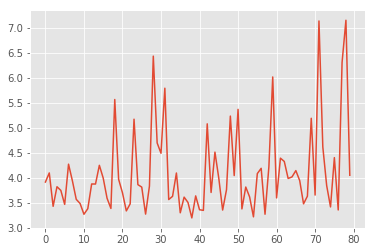

In [6]:
results['mape'].plot()

This cell plots the last prediction made in the validation loop.

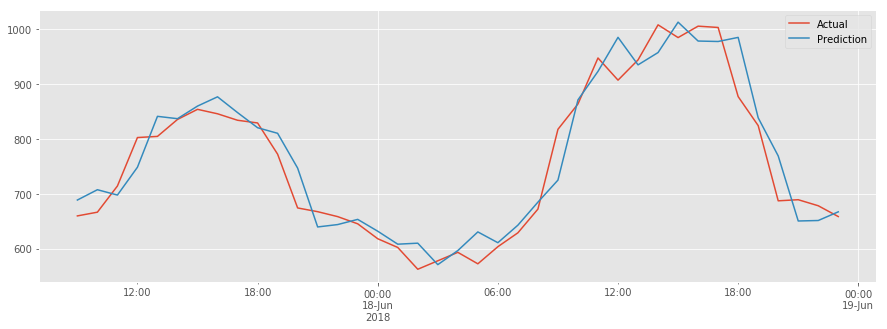

In [7]:
# construct dataframe with actual and predicted data for the test period, then plot
comparison = pd.DataFrame(y_test,columns=['Actual'])                  
comparison['Prediction'] = reg.predict(X_test)
comparison.plot(figsize=(15, 5))